# PCA and Clustering (MITXPro)

PCA and Clustering Python code example based on:

Gorban, Alexander N., and Andrei Y. Zinovyev. "PCA and K-means decipher genome." *Principal manifolds for data visualization and dimension reduction*. Springer, Berlin, Heidelberg, 2008. 309-323.

In [1]:
import numpy as np
import os.path
import urllib
import gzip
from StringIO import StringIO
import itertools
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig_size = [8, 8]
plt.rcParams["figure.figsize"] = fig_size

If the data was not downloaded, do it now

In [2]:
fname="Caulobacter_crescentus_na1000.ASM2200v1.dna.toplevel.fa"
url="ftp://ftp.ensemblgenomes.org/pub/bacteria/release-37/fasta"+\
    "/bacteria_20_collection/caulobacter_crescentus_na1000/dna/"+\
    fname+".gz"

In [3]:
def checkGenome(url, fname):
    if not os.path.isfile(fname):
        url=urllib.urlopen(url)
        buf = StringIO(url.read())
        gz = gzip.GzipFile(fileobj=buf)
        with open(fname, "w") as f:
            f.write(gz.read())
        print("file downloaded")
    else:
        print("you already have the file")

checkGenome(url, fname)

file downloaded


In [4]:
def loadGenome(fname):
    genome=""
    with open(fname, "r") as f:
        _ = f.readline() # ignore the header
        l = f.readline()
        while l:
            genome += l[:-1] # ignore new line
            l = f.readline()
    GENOMESIZE=len(genome)
    return genome, GENOMESIZE

genome, GENOMESIZE = loadGenome(fname)

Let me check if we have only 'A', 'C', 'G' and 'T':

In [5]:
letters=list(set(genome))
print letters

['A', 'C', 'T', 'G']


Looks good!

Defining some parameters:

In [6]:
BLOCKSIZE=300
WORDSIZE=[1,2,3,4]
NBLOCKS=GENOMESIZE//BLOCKSIZE

Define feature vectors as in the paper, i.e. counting number of each possible word in each block.

In [7]:
def getFeatures(genome, NBLOCKS, WORDSIZE):
    features={x : np.zeros((NBLOCKS, 4**x)) for x in WORDSIZE}
    for ws in WORDSIZE:
        lookUp = { y : x for x,y in enumerate([''.join(l) for l in itertools.product(*[letters]*ws)]) }
        for b in range(NBLOCKS):
            block = genome[b*BLOCKSIZE:(b+1)*BLOCKSIZE]
            for i in range(BLOCKSIZE//ws):
                word = block[i*ws:(i+1)*ws]
                features[ws][b,lookUp[word]] += 1
    return features

features = getFeatures(genome, NBLOCKS, WORDSIZE)

Standardize data:

In [8]:
def standardize(features, WORDSIZE):
    for ws in WORDSIZE:
        std_scale = preprocessing.StandardScaler().fit(features[ws])
        features[ws] = std_scale.transform(features[ws])
    return features

features = standardize(features, WORDSIZE)

Run PCA:

In [9]:
def runPCA(features, WORDSIZE, n_components=2):
    featuresPCA={}
    for ws in WORDSIZE:
        pca = PCA(n_components=n_components).fit(features[ws])
        featuresPCA[ws] = pca.transform(features[ws])
    return featuresPCA

featuresPCA = runPCA(features, WORDSIZE)

Plot:

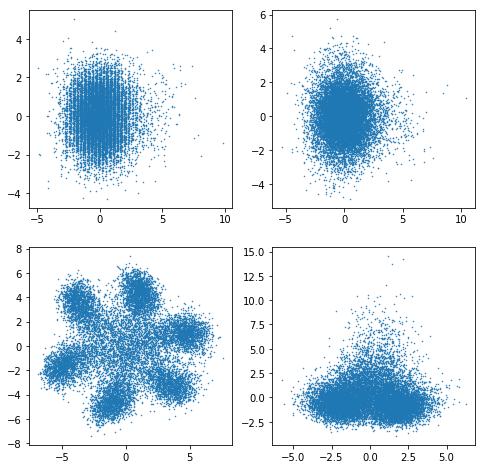

In [10]:
fig, axes = plt.subplots(2,2)
axes[0,0].scatter(featuresPCA[1].T[0], featuresPCA[1].T[1], s=0.25)
axes[0,1].scatter(featuresPCA[2].T[0], featuresPCA[2].T[1], s=0.25)
axes[1,0].scatter(featuresPCA[3].T[0], featuresPCA[3].T[1], s=0.25)
axes[1,1].scatter(featuresPCA[4].T[0], featuresPCA[4].T[1], s=0.25)

It looks really similar to the results in the paper, so I run kmeans:

In [11]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(features[3])

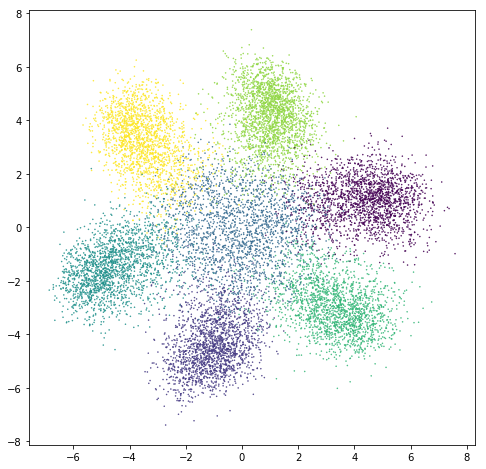

In [12]:
fig, ax = plt.subplots(1,1)
ax.scatter(featuresPCA[3].T[0], featuresPCA[3].T[1], s=0.25, c=kmeans.labels_)

### Escherichia Coli

Now I tried to do the same with Escherichia Coli genome.

In [13]:
fname="GCA_000005845.2_ASM584v2_genomic.fna"
url="ftp://ftp.ncbi.nlm.nih.gov/genomes/genbank/bacteria/"+\
    "Escherichia_coli/reference/GCA_000005845.2_ASM584v2/"+\
    fname+".gz"

In [14]:
checkGenome(url, fname)
genome, GENOMESIZE = loadGenome(fname)

NBLOCKS=GENOMESIZE//BLOCKSIZE

features = getFeatures(genome, NBLOCKS, WORDSIZE)
features = standardize(features, WORDSIZE)
featuresPCA = runPCA(features, WORDSIZE)

file downloaded


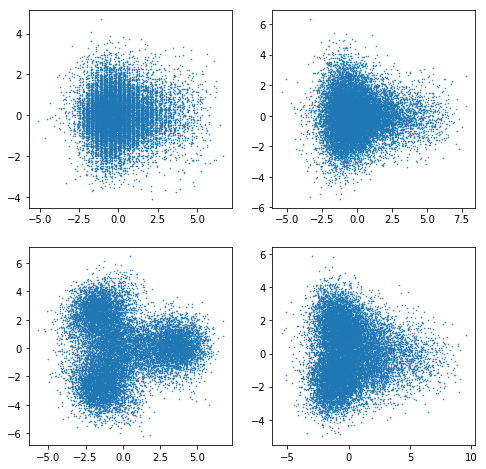

In [15]:
fig, axes = plt.subplots(2,2)
axes[0,0].scatter(featuresPCA[1].T[0], featuresPCA[1].T[1], s=0.25)
axes[0,1].scatter(featuresPCA[2].T[0], featuresPCA[2].T[1], s=0.25)
axes[1,0].scatter(featuresPCA[3].T[0], featuresPCA[3].T[1], s=0.25)
axes[1,1].scatter(featuresPCA[4].T[0], featuresPCA[4].T[1], s=0.25)

The result is not similar though to the previous result. It appears to have three or four blobs in the lenght three word, but it is not as clean as before. In this case I tried a Gaussian Mixture model that has the nice property of giving probabilities over each of of the classes (here I choose 4 classes).

In [16]:
gmm=GaussianMixture(n_components=4,covariance_type="spherical", max_iter=40, random_state=0)
gmm.fit(features[3])

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=40, means_init=None, n_components=4, n_init=1,
        precisions_init=None, random_state=0, reg_covar=1e-06, tol=0.001,
        verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

In [17]:
res=gmm.predict_proba(features[3])

Plotting as a linear combination of four colors (based on their probabilities):

In [18]:
colors=np.stack([np.array(matplotlib.colors.to_rgb('cyan')),
                 np.array(matplotlib.colors.to_rgb('magenta')),
                 np.array(matplotlib.colors.to_rgb('yellow')),
                 np.array(matplotlib.colors.to_rgb('black'))])

In [19]:
clss=np.dot(res, colors)

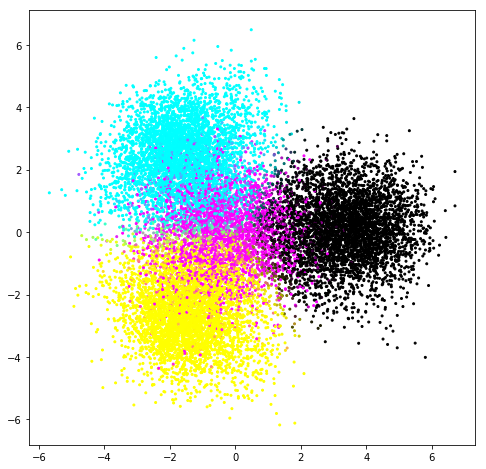

In [20]:
fig, ax = plt.subplots(1,1)
ax.scatter(featuresPCA[3].T[0], featuresPCA[3].T[1], s=4, c=clss)

There is another interesting tutorial about PCA in a BerkeleyX course. It used to be CS190.1x , but this is not available anymore. There is this one, but I am not sure if it has the PCA tutorial that uses Spark:

  https://www.edx.org/xseries/data-science-engineering-apache-spark

I believe this paper gives some info about the particular application:

  https://www-cs.stanford.edu/~matei/courses/2015/6.S897/readings/freeman-2014.pdf